# COMPS II
### A notebook for producing paper-quality figures and captions for my upcoming COMPS-II paper.
##### Initialized by Drew Camron Sep 2018

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np

from pyresample import geometry, image
roi=10e6    # For any radius_of_influence pyresample calculations

import matplotlib.pyplot as plt
#from matplotlib import rcParams
import seaborn as sns
import cartopy.crs as ccrs

In [2]:
sns.set(context='poster', style='ticks', rc={'lines.linewidth': 5})
#rcParams.update({'figure.autolayout': True})

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37070 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [4]:
indir_rcp = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_1850 = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_obs = '/glade/work/mcamron/obs/cloudsat/tristan/'
indir_mask = '/glade/work/mcamron/gismask_RACMO23_0.9x1.25_con.nc'
indir_topo = '/glade/work/mcamron/USGS-gtopo30_0.9x1.25_remap_c051027.nc'

In [5]:
ds_vars = ['RADAR_LGTRAIN', 'RADAR_LGTRAINO', 'RADAR_RAIN', 'RADAR_RAINO', 'RADAR_LGTSNOW', 'RADAR_LGTSNOWO', 'RADAR_SNOW', 'RADAR_SNOWO', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL']

fn_tseries_rcp = 'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fn_tseries_1850 = 'b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fext_tseries_rcp = '.200601-209512.nc'
fext_tseries_1850 = '.000101-010012.nc'

fnames_rcp = [indir_rcp + fn_tseries_rcp + var + fext_tseries_rcp for var in ds_vars]
fnames_1850 = [indir_1850 + fn_tseries_1850 + var + fext_tseries_1850 for var in ds_vars]

obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [indir_obs+file for file in os.listdir(indir_obs) if mo+yr in file]

ds_rcp = xr.open_mfdataset(fnames_rcp, decode_times=False).sel(lat=slice(0, 90))
newlons = [(lon - 360) if (lon > 179) else lon for lon in ds_rcp.lon.values]
ds_rcp = ds_rcp.assign_coords(lon=newlons).roll(lon=(ds_rcp.dims['lon'] // 2), roll_coords=True)
ds_1850 = xr.open_mfdataset(fnames_1850, decode_times=False).sel(lat=slice(0, 90))
ds_1850 = ds_1850.assign_coords(lon=newlons).roll(lon=(ds_1850.dims['lon'] // 2), roll_coords=True)
ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ds_rcp['time'] = pd.date_range('2006-01', '2095-12', freq='MS')
ds_1850['time'] = pd.date_range('2006-01', '2105-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))
#ds_obs = ds_obs.assign_coords(longitude=(ds_obs.longitude % 360)).roll(longitude=(ds_obs.dims['longitude'] // 2))

ds_mask = xr.open_dataset(indir_mask).sel(lat=slice(0, 90))
ds_mask = ds_mask.assign_coords(lon=newlons).roll(lon=(ds_mask.dims['lon'] // 2), roll_coords=True)
#ms = ds_mask['GrIS_mask'].where(ds_mask['GrIS_mask'] > 0)

ds_topo = xr.open_dataset(indir_topo)
ds_topo = (ds_topo
           .sel(lat=(ds_topo['lat'] > 0))
           .assign_coords(lat=ds_rcp['lat'])
           .assign_coords(lon=newlons)
           .roll(lon=(ds_topo.dims['lon'] // 2), roll_coords=True))

In [6]:
ds_pres = (ds_rcp[ds_vars].isel(time=slice(0, 180)))
ds_fut = (ds_rcp[ds_vars].isel(time=slice(-181, -1)))

rain_pres = (
    ds_pres['RADAR_RAIN'] + ds_pres['RADAR_LGTRAIN'])
snow_pres = (
    ds_pres['RADAR_SNOW'] + ds_pres['RADAR_LGTSNOW'])

rain_fut = (
    ds_fut['RADAR_RAIN'] + ds_fut['RADAR_LGTRAIN'])
snow_fut = (
    ds_fut['RADAR_SNOW'] + ds_fut['RADAR_LGTSNOW'])

rain_obs = (
    (ds_obs['raincounts'] + #ds_obs['heavyraincounts'] +    # heavy rain is a subset of rain certain
     ds_obs['probablecounts'] + ds_obs['possiblecounts']) / ds_obs['counts']) * 100
snow_obs = (
    (ds_obs['snowcounts'] + ds_obs['snowpossiblecounts']) / ds_obs['counts']) * 100

---
## Figure 1
`CLOUDSAT` sum rain frequency and sum snow frequency maps, shown annually and seasonally.

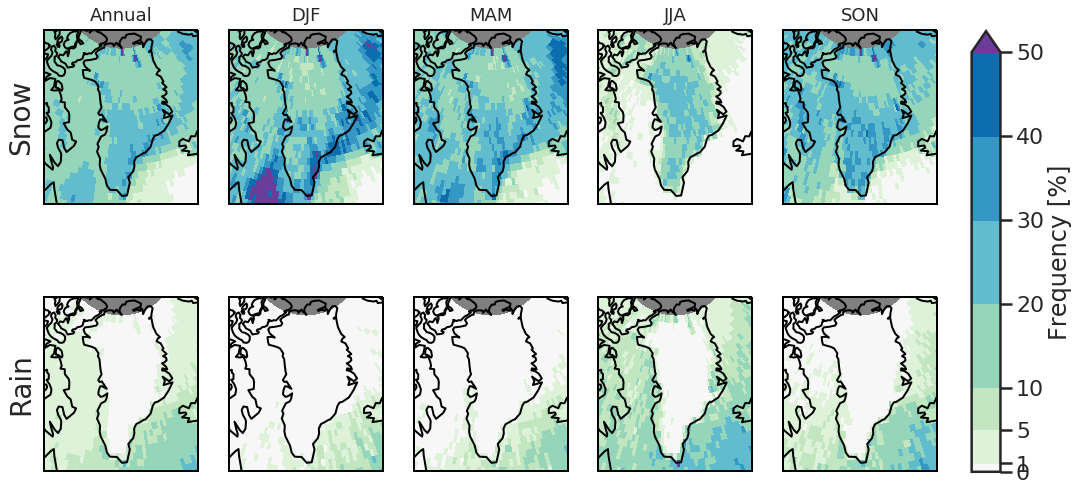

In [7]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']

levels = [0, 1, 5, 10, 20, 30, 40, 50]
colors = [(247/255, 247/255, 247/255)] 
colors += sns.color_palette('GnBu', len(levels) - 2)
colors += [(106/255, 61/255, 154/255)]

p = (snow_obs
     .mean('time')
     .plot.pcolormesh(
         ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    (snow_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    

(rain_obs
 .mean('time')
 .plot.pcolormesh(
     ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    (rain_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
      
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])
    ax.background_patch.set_facecolor('gray')

#plt.tight_layout()
    
cb_ax = f.add_axes([0.93, 0.161, 0.025, 0.68])
cb = f.colorbar(p, cax=cb_ax, extend='max', spacing='proportional')
cb.ax.set_ylabel('Frequency [%]')
    
axes[0, 0].text(-0.15, 0.5, 'Snow', fontsize=28, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.15, 0.5, 'Rain', fontsize=28,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Figure1_mapgrid-cloudsat.png',
         bbox_extra_artists=[ax for l in f.axes], bbox_inches='tight')

---
## Figure 2
Greenland mean seasonal cycle separated by variable.

In [8]:
obs_vars = ['raincounts', 'snowcounts', 'snowpossiblecounts']
dsetdict = {var: ds_obs[var] for var in ds_obs[obs_vars].data_vars}
dsetdict['lgtrain'] = (ds_obs['possiblecounts'] + ds_obs['probablecounts'])
obs_lgtrain = xr.Dataset(dsetdict)

In [9]:
obs_mask_indir = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_Topo_GrIS_CC_final.nc'
obs_mask = xr.open_dataset(obs_mask_indir).sel(lat=slice(0, 90)).rename({'lon': 'longitude', 'lat': 'latitude'})

In [10]:
x, y = np.meshgrid((ds_mask['lon'].values.astype('float32')), ds_mask['lat'])
xx, yy = np.meshgrid(ds_obs['longitude'], ds_obs['latitude']) 

ms_grid = geometry.GridDefinition(lons=x, lats=y)
obs_grid = geometry.GridDefinition(lons=xx, lats=yy)

In [11]:
obs_w = ((((obs_lgtrain / ds_obs['counts']) * 100 * obs_mask['mask'].where(obs_mask['mask'] > 0) * obs_mask['cell_area'])
          .sum('latitude').sum('longitude') / (obs_mask['mask'] * obs_mask['cell_area']).sum()))

Some `Figure 1` area-weighted seasonal averages for manuscript.

In [12]:
rain_w_seas = (obs_w['raincounts'] + obs_w['lgtrain']).groupby('time.season').mean('time', skipna=True).values
rain_w_mean = rain_w_seas.mean()

snow_w_seas = (obs_w['snowcounts'] + obs_w['snowpossiblecounts']).groupby('time.season').mean('time', skipna=True).values
snow_w_mean = snow_w_seas.mean()

print(f'Rain: Annual {rain_w_mean}, [DJF, JJA, MAM, SON] {rain_w_seas}')
print(f'Snow: Annual {snow_w_mean}, [DJF, JJA, MAM, SON] {snow_w_seas}')

Rain: Annual 0.3180666392487178, [DJF, JJA, MAM, SON] [0.00537633 0.98142318 0.09199521 0.19347184]
Snow: Annual 19.325785130011354, [DJF, JJA, MAM, SON] [20.10644938 15.61922819 19.69423326 21.88322969]


In [13]:
obs_plotvars = ['snowcounts', 'snowpossiblecounts', 'raincounts', 'lgtrain']
obs_vnames = ['Snow', 'Light snow', 'Rain', 'Light Rain']
obs_lstyle = ['solid', 'dashed', 'solid', 'dashed']
obs_colors = [2, 2, 0, 0]

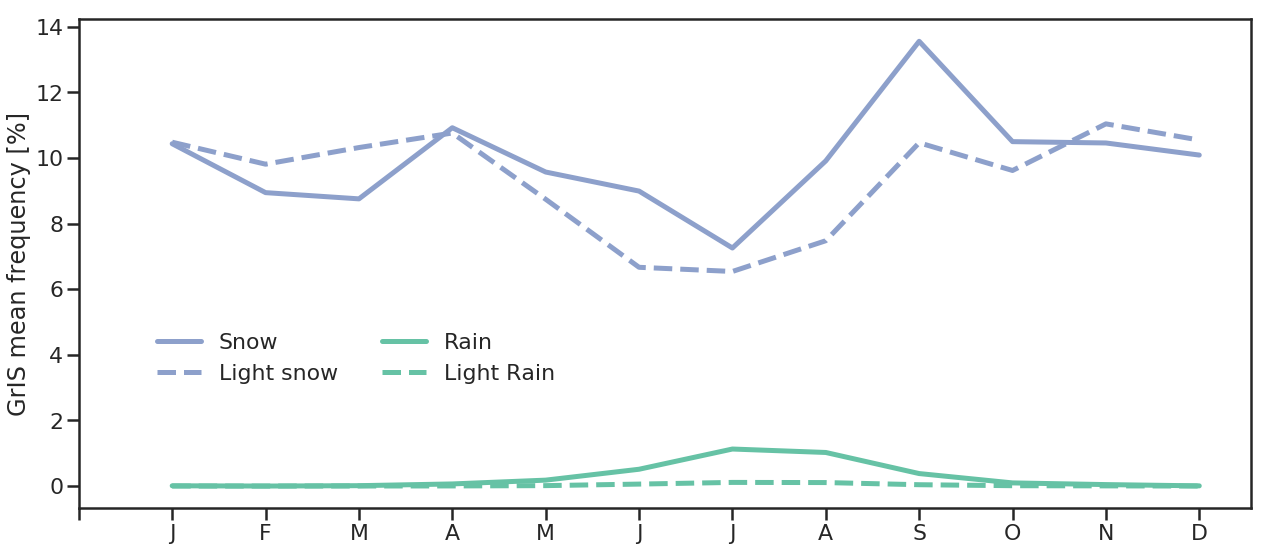

In [15]:
f, ax = plt.subplots(figsize=(21, 9))

for var, name, style, color in zip(obs_plotvars, obs_vnames, obs_lstyle, obs_colors):
    (
        obs_w[var]
        .groupby('time.month')
        .mean('time', skipna=True)
        .plot(ax=ax, label=name, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

ax.legend(loc=2, bbox_to_anchor=(0.05, 0.4), ncol=2, frameon=False)
plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel('GrIS mean frequency [%]')
ax.set_xlabel('')

f.savefig('../figures/comps2/Figure2_GIS-obs-mean-cycle.png',
          bbox_inches='tight')

---
## Figure 3
Top: a distribution of precip frequencies by elevation. Bottom: distribution of total area of grids by elevation.

In [16]:
model_mask_indir = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_Topo_GrIS_SM_final.nc'
model_mask = xr.open_dataset(model_mask_indir)
model_mask = (model_mask
              .sel(lat=(model_mask['lat'] >= 0))
              .assign_coords(lat=ds_pres.lat)
              .assign_coords(lon=newlons)
              .roll(lon=(model_mask.dims['lon'] // 2), roll_coords=True)
             )

In [17]:
bins = np.arange(0, 3750, 250)

In [18]:
g = 9.80665
topo_cesm = ds_topo['PHIS'] / g

Here is where I've messedup, going to change.

In [19]:
snow_obs_elev = ((snow_obs * obs_mask['cell_area'])
                 .where(obs_mask['mask'] > 0)
                 .mean('time')
                 .groupby_bins(obs_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS) / 
                 (obs_mask['cell_area'])
                 .where(obs_mask['mask'] > 0)
                 .groupby_bins(obs_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS)
                )

rain_obs_elev = ((rain_obs * obs_mask['cell_area'])
                 .mean('time')
                 .where(obs_mask['mask'] > 0)
                 .groupby_bins(obs_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS) / 
                 (obs_mask['cell_area'])
                 .where(obs_mask['mask'] > 0)
                 .groupby_bins(obs_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS)
                )

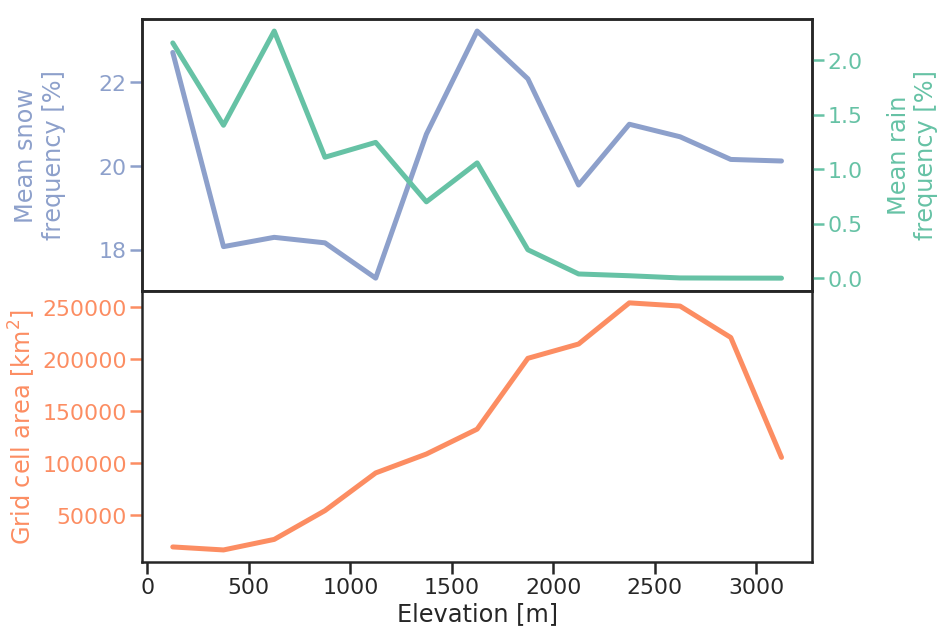

In [20]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot((bins[:-1]+125), snow_obs_elev, color=sns.color_palette('Set2')[2])

axy = axes[0].twinx()
axy.plot((bins[:-1]+125), rain_obs_elev, color=sns.color_palette('Set2')[0], label='CloudSat 2CPC')

axes[1].plot(
    bins[:-1]+125, (obs_mask['cell_area'].where(obs_mask['mask'] > 0).groupby_bins(obs_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])
#axes[0].set_ylim([11.5, 24.5])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])
#axy.set_ylim([-0.5, 4.5])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')
axes[1].set_xlabel('Elevation [m]')

f.savefig('../figures/comps2/Figure3_elev-dist-obs.png',
         bbox_inches='tight')

---
## Figure 4
`CESM present` bias maps relative to `CLOUDSAT` observations, ie as in **Figure 1** (`CESM present` - `CLOUDSAT`).

In [21]:
snow_pres_seasonal = snow_pres.groupby('time.season').mean('time').values
rain_pres_seasonal = rain_pres.groupby('time.season').mean('time').values

snow_pres_mean = np.zeros((4, ds_obs.dims['latitude'], ds_obs.dims['longitude']))
rain_pres_mean = np.zeros((4, ds_obs.dims['latitude'], ds_obs.dims['longitude']))

for i in range(0, 4):
    snow_pres_image = image.ImageContainerNearest(snow_pres_seasonal[i, :, :], geo_def=ms_grid, radius_of_influence=roi)
    snow_pres_mean[i] = snow_pres_image.resample(obs_grid).image_data

    rain_pres_image = image.ImageContainerNearest(rain_pres_seasonal[i, :, :], geo_def=ms_grid, radius_of_influence=roi)
    rain_pres_mean[i] = rain_pres_image.resample(obs_grid).image_data

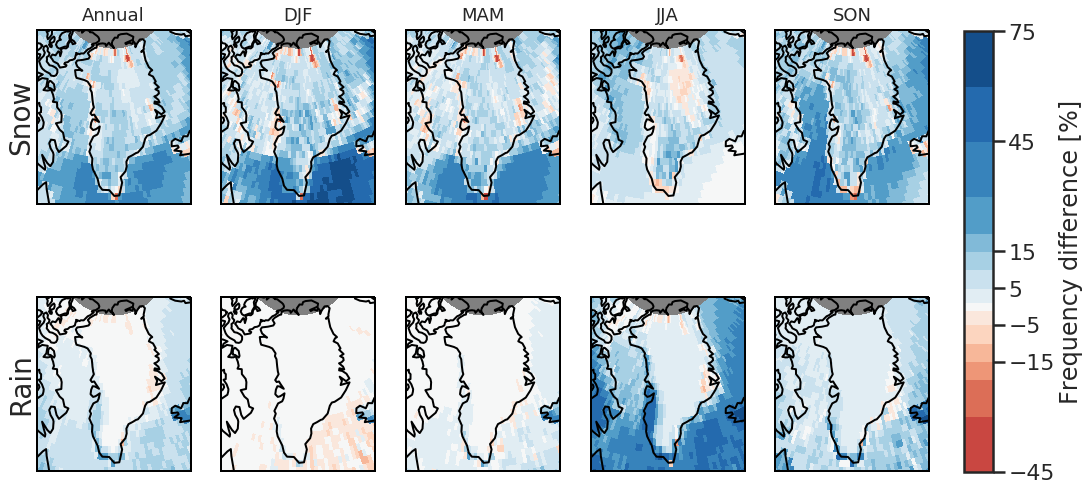

In [22]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']

#vm = 20
#levels = list(np.arange(-vm, vm+4, 4))
#levels = [-45, -30, -15, -10, -5, -1]
levels = [-45, -30, -20, -15, -10, -5, -1, 1, 5, 10, 15, 20, 30, 45, 60, 75]
ticks = levels[::2]
#levels.extend([abs(x) for x in levels[-1::-1]])
#ticks.extend([abs(x) for x in ticks[-1::-1]])
colors = sns.color_palette('RdBu', len(levels)+1)[2:]

p = ((snow_pres_mean - snow_obs.groupby('time.season').mean('time'))
     .mean('season')
     .plot.pcolormesh(
         ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=levels, colors=colors)
    )

for i, x in enumerate(seasons):
    ((snow_pres_mean - snow_obs.groupby('time.season').mean('time'))
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

((rain_pres_mean - rain_obs.groupby('time.season').mean('time'))
 .mean('season')
 .plot.pcolormesh(
     ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    ((rain_pres_mean - rain_obs.groupby('time.season').mean('time'))
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

    
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])
    ax.background_patch.set_facecolor('gray')

#plt.tight_layout()
    
cb_ax = f.add_axes([0.93, 0.161, 0.025, 0.68])
cb = f.colorbar(p, cax=cb_ax, extend='neither', spacing='proportional',
                ticks=[-45, -15, -5, 5, 15, 45, 75])
cb.ax.set_ylabel('Frequency difference [%]')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=28, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=28,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Figure4_mapgrid-cesm-pres.png',
         bbox_extra_artists=[ax for l in f.axes], bbox_inches='tight')

---
## Figure 5
CESM 1 `present` mean seasonal cycle, ie as in **Figure 2**.

In [23]:
model_vars = ['RADAR_RAIN', 'RADAR_LGTRAIN', 'RADAR_SNOW', 'RADAR_LGTSNOW']

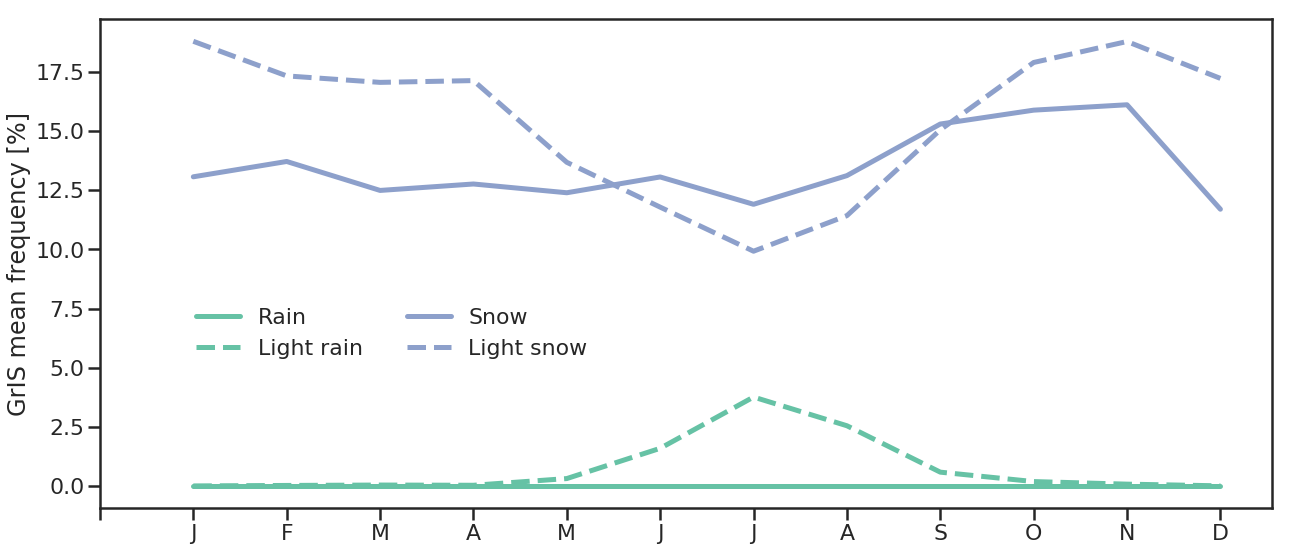

In [31]:
f, ax = plt.subplots(figsize=(21, 9))

model_vnames = ['Rain', 'Light rain', 'Snow', 'Light snow']
model_lstyle = ['solid', 'dashed', 'solid', 'dashed']
model_colors = [0, 0, 2, 2]
for var, name, style, color in zip(model_vars, model_vnames, model_lstyle, model_colors):
    ((
        (ds_pres[var] * model_mask['mask'].where(model_mask['mask'] > 0) * model_mask['cell_area'])
        .sum('lat').sum('lon') / (model_mask['mask'] * model_mask['cell_area']).sum())
        .groupby('time.month')
        .mean('time', skipna=True)
        .plot(ax=ax, label=name, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

ax.legend(loc=2, bbox_to_anchor=(0.065, 0.45), ncol=2, frameon=False)
plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel('GrIS mean frequency [%]')
ax.set_xlabel('')

f.savefig('../figures/comps2/Figure5_GIS-pres-mean-cycle.png', bbox_inches='tight')

---
## Figure 6
CESM frequency vs accumulation.

In [25]:
#precvars = [var for var in ds_pres.data_vars if 'PREC' in var]
precvars = ['PRECL', 'PRECSL']
radarvars = [var for var in ds_pres.data_vars if 'RADAR' in var if 'RAINO' not in var if 'SNOWO' not in var if '_RAIN' not in var]

In [26]:
# Converting PREC* vars from m/s to mm/day
ds_fig6 = xr.merge([(ds_pres[precvars] * 1000 * 86400), 
                    ds_pres[radarvars]])

In [27]:
df_fig6 = ds_fig6.where((model_mask['mask'] > 0), drop=True).mean('time').to_dataframe().reset_index().dropna()

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


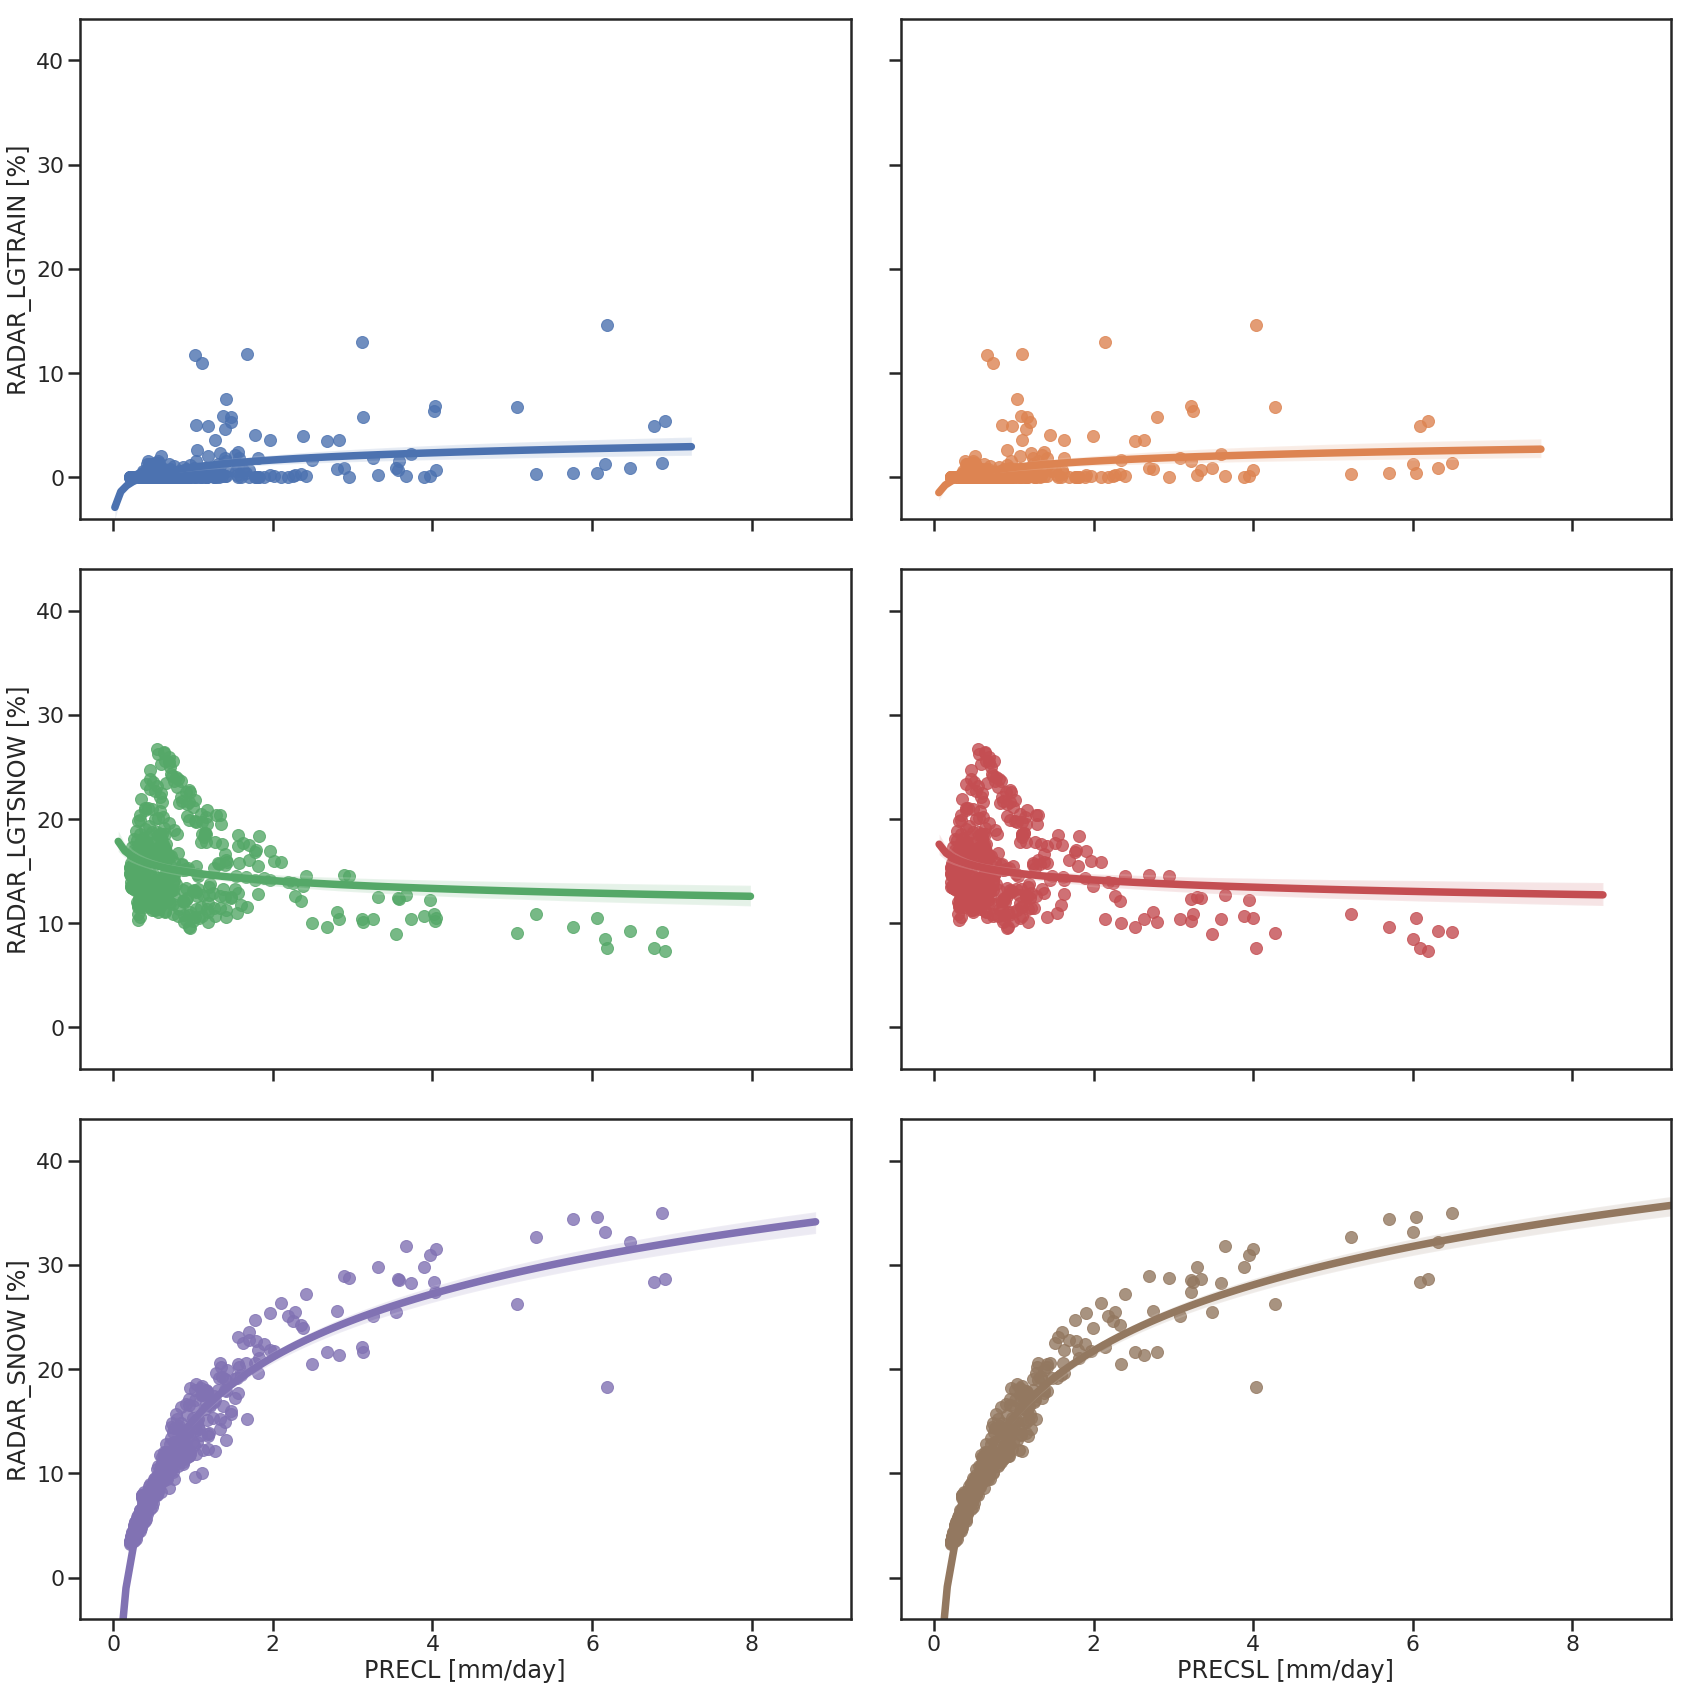

In [28]:
f, axes = plt.subplots(len(radarvars), len(precvars), figsize=(24, 24), sharex=True, sharey=True)

for iy, y in enumerate(radarvars):
    for ix, x in enumerate(precvars):
        sns.regplot(x=x, y=y, data=df_fig6, ax=axes[iy, ix], logx=True)
        
for ax in axes.flat:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-4, 44])
    
for i, x in enumerate(precvars):
    axes[-1, i].set_xlabel(x+' [mm/day]')
    
for i, y in enumerate(radarvars):
    axes[i, 0].set_ylabel(y+' [%]')
    
f.tight_layout()
f.savefig('../figures/comps2/Figure6_freq-accum-scatter.png', bbox_inches='tight')

### Spacial correlations

---
## Figure 7
`CESM present` and `future` elevation distrubtions as in **Figure 3**.

In [32]:
snow_pres_elev = ((snow_pres * model_mask['cell_area'])
                 .where(model_mask['mask'] > 0)
                 .mean('time')
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS) / 
                 (model_mask['cell_area'])
                 .where(model_mask['mask'] > 0)
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS)
                )

rain_pres_elev = ((rain_pres * model_mask['cell_area'])
                 .mean('time')
                 .where(model_mask['mask'] > 0)
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS) / 
                 (model_mask['cell_area'])
                 .where(model_mask['mask'] > 0)
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS)
                )

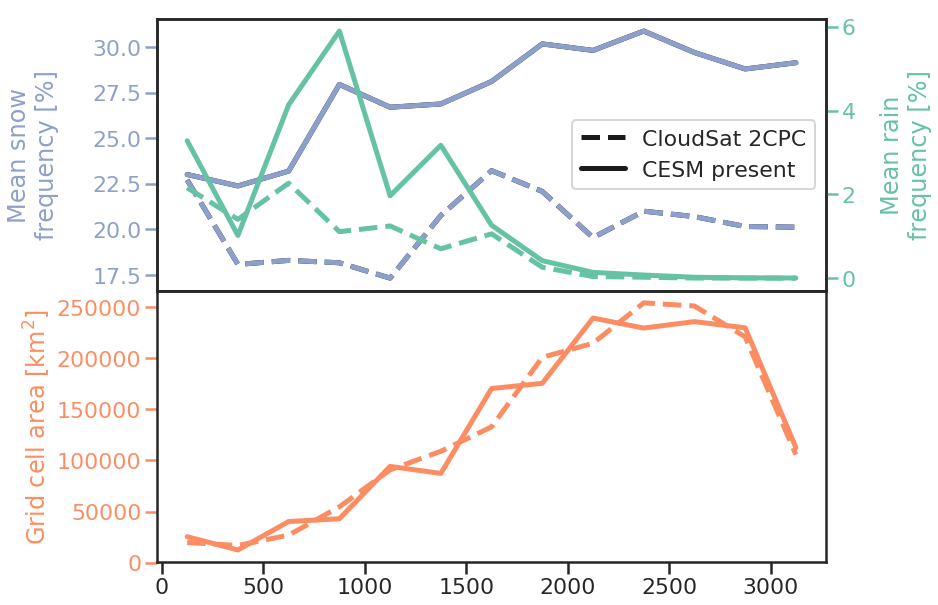

In [33]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot((bins[:-1]+125), snow_obs_elev, color='k', label='CloudSat 2CPC', linestyle='dashed')
axes[0].plot((bins[:-1]+125), snow_pres_elev, color='k', label='CESM present')

axes[0].plot((bins[:-1]+125), snow_obs_elev, color=sns.color_palette('Set2')[2], linestyle='dashed')
axes[0].plot((bins[:-1]+125), snow_pres_elev, color=sns.color_palette('Set2')[2])

axy = axes[0].twinx()
axy.plot((bins[:-1]+125), rain_obs_elev, color=sns.color_palette('Set2')[0], label='CloudSat 2CPC', linestyle='dashed')
axy.plot((bins[:-1]+125), rain_pres_elev, color=sns.color_palette('Set2')[0], label='CESM present')


axes[1].plot(
    bins[:-1]+125, (obs_mask['cell_area'].where(obs_mask['mask'] > 0).groupby_bins(obs_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1], linestyle='dashed')

axes[1].plot(
    bins[:-1]+125, (model_mask['cell_area'].where(model_mask['mask'] > 0).groupby_bins(model_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].legend(loc='center right')
axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])
#axes[0].set_ylim([11.5, 24.5])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])
#axy.set_ylim([-0.5, 4.5])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Figure7_elev-dist-presobs.png', bbox_inches='tight')

In [34]:
snow_fut_elev = ((snow_fut * model_mask['cell_area'])
                 .where(model_mask['mask'] > 0)
                 .mean('time')
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS) / 
                 (model_mask['cell_area'])
                 .where(model_mask['mask'] > 0)
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS)
                )

rain_fut_elev = ((rain_fut * model_mask['cell_area'])
                 .mean('time')
                 .where(model_mask['mask'] > 0)
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS) / 
                 (model_mask['cell_area'])
                 .where(model_mask['mask'] > 0)
                 .groupby_bins(model_mask['Topography'], bins, right=False)
                 .sum(dim=xr.ALL_DIMS)
                )

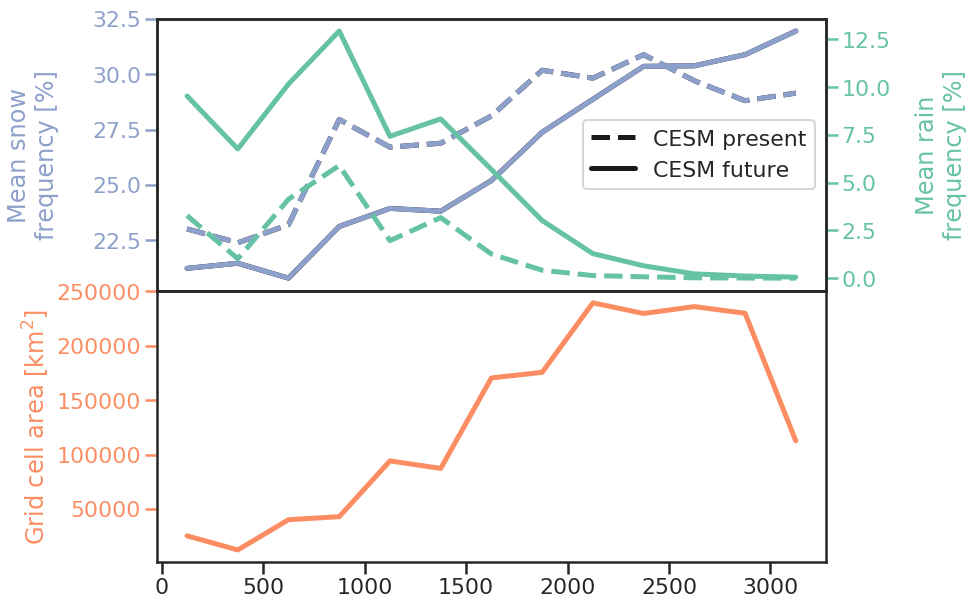

In [35]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot((bins[:-1]+125), snow_pres_elev, color='k', label='CESM present', linestyle='dashed')
axes[0].plot((bins[:-1]+125), snow_fut_elev, color='k', label='CESM future')

axes[0].plot((bins[:-1]+125), snow_pres_elev, color=sns.color_palette('Set2')[2], linestyle='dashed')
axes[0].plot((bins[:-1]+125), snow_fut_elev, color=sns.color_palette('Set2')[2])

axy = axes[0].twinx()
axy.plot((bins[:-1]+125), rain_pres_elev, color=sns.color_palette('Set2')[0], label='CESM present', linestyle='dashed')
axy.plot((bins[:-1]+125), rain_fut_elev, color=sns.color_palette('Set2')[0], label='CESM future')

axes[1].plot(
    bins[:-1]+125, (model_mask['cell_area'].where(model_mask['mask'] > 0).groupby_bins(model_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].legend(loc='center right')
axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])
#axes[0].set_ylim([11.5, 24.5])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])
#axy.set_ylim([-0.5, 4.5])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Figure7_elev-dist-futpres.png', bbox_inches='tight')

---
## Figure 8
`CESM future` - `present` bias maps, annual only.

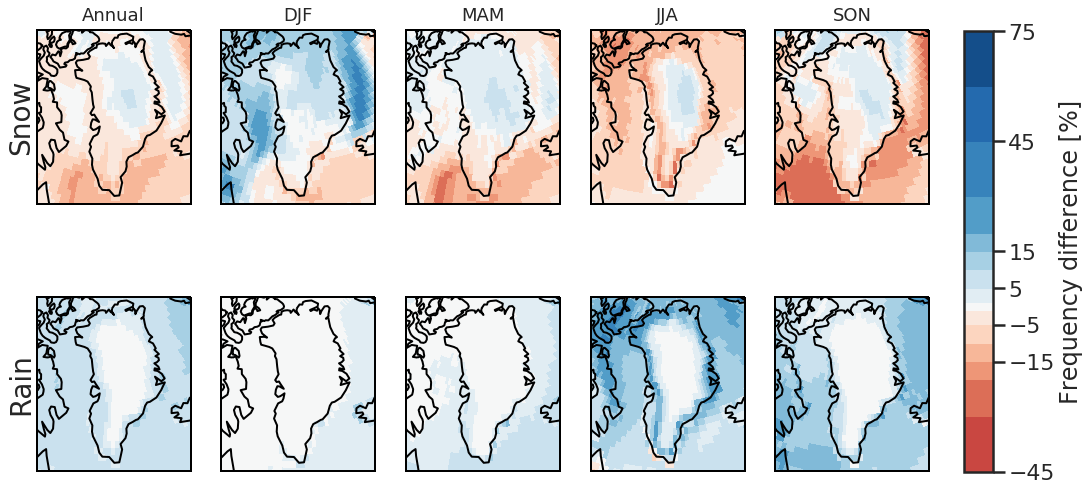

In [36]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']

levels = [-45, -30, -20, -15, -10, -5, -1, 1, 5, 10, 15, 20, 30, 45, 60, 75]
ticks = levels[::2]
colors = sns.color_palette('RdBu', len(levels)+1)[2:]

p = ((snow_fut.groupby('time.season').mean('time') - snow_pres.groupby('time.season').mean('time'))
     .mean('season')
     .plot.pcolormesh(
         ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=levels, colors=colors)
    )

for i, x in enumerate(seasons):
    ((snow_fut.groupby('time.season').mean('time') - snow_pres.groupby('time.season').mean('time'))
     .sel(season=x)
     .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

((rain_fut.groupby('time.season').mean('time') - rain_pres.groupby('time.season').mean('time'))
 .mean('season')
 .plot.pcolormesh(
     ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    ((rain_fut.groupby('time.season').mean('time') - rain_pres.groupby('time.season').mean('time'))
     .sel(season=x)
     .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

    
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])
    ax.background_patch.set_facecolor('gray')

#plt.tight_layout()
    
cb_ax = f.add_axes([0.93, 0.161, 0.025, 0.68])
cb = f.colorbar(p, cax=cb_ax, extend='neither', spacing='proportional',
                ticks=[-45, -15, -5, 5, 15, 45, 75])
cb.ax.set_ylabel('Frequency difference [%]')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=28, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=28,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Figure8_mapgrid-cesm-pres.png',
         bbox_extra_artists=[ax for l in f.axes], bbox_inches='tight')

---
## Figure 9
`CESM future` - `present` seasonal cycle change.

In [37]:
model_vars = ['RADAR_RAIN', 'RADAR_LGTRAIN', 'RADAR_SNOW', 'RADAR_LGTSNOW']
model_vnames = ['Rain', 'Light rain', 'Snow', 'Light snow']
model_lstyle = ['solid', 'dashed', 'solid', 'dashed']
model_colors = [0, 0, 2, 2]

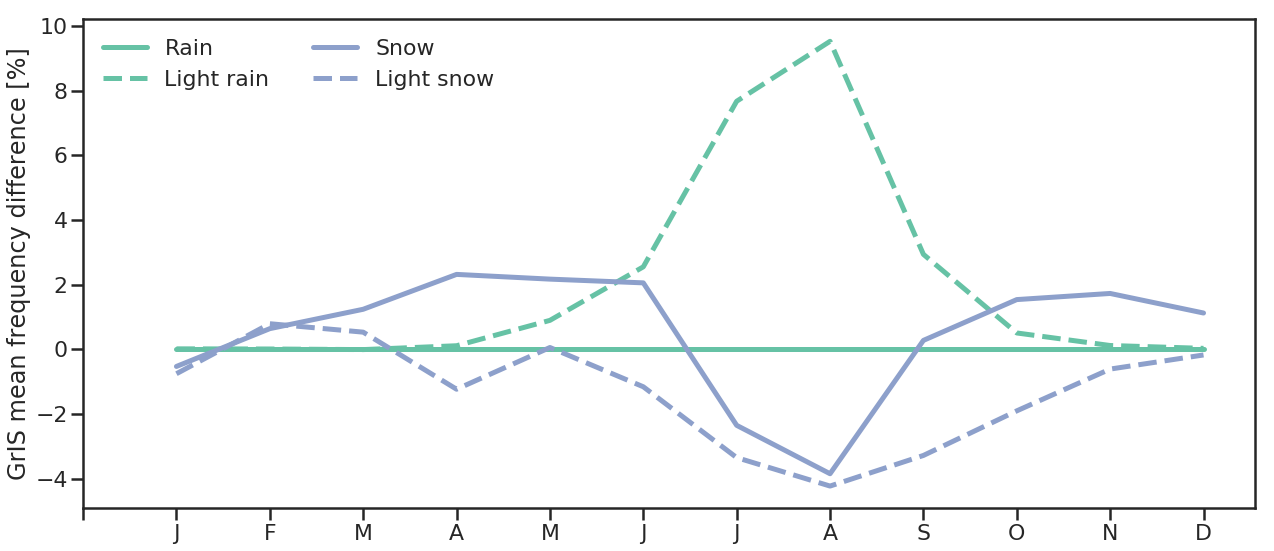

In [38]:
f, ax = plt.subplots(figsize=(21, 9))

for var, name, style, color in zip(model_vars, model_vnames, model_lstyle, model_colors):
    (((((ds_fut[var] * model_mask['cell_area']).where(model_mask['mask'] > 0).sum('lat').sum('lon') /
        model_mask['cell_area'].where(model_mask['mask'] > 0).sum()).groupby('time.month').mean('time')) - 
      (((ds_pres[var] * model_mask['cell_area']).where(model_mask['mask'] > 0).sum('lat').sum('lon') /
        model_mask['cell_area'].where(model_mask['mask'] > 0).sum()).groupby('time.month').mean('time')))
     .plot(ax=ax, label=name, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

ax.legend(loc='upper left', ncol=2, frameon=False)
plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel('GrIS mean frequency difference [%]')
ax.set_xlabel('')

f.savefig('../figures/comps2/Figure9_GIS-futurebias-mean-cycle.png', bbox_inches='tight')

---
## Figure 10
Time of emergence.

---
## Supplemental

### Supp to Fig 1
Breaking down precip maps by category

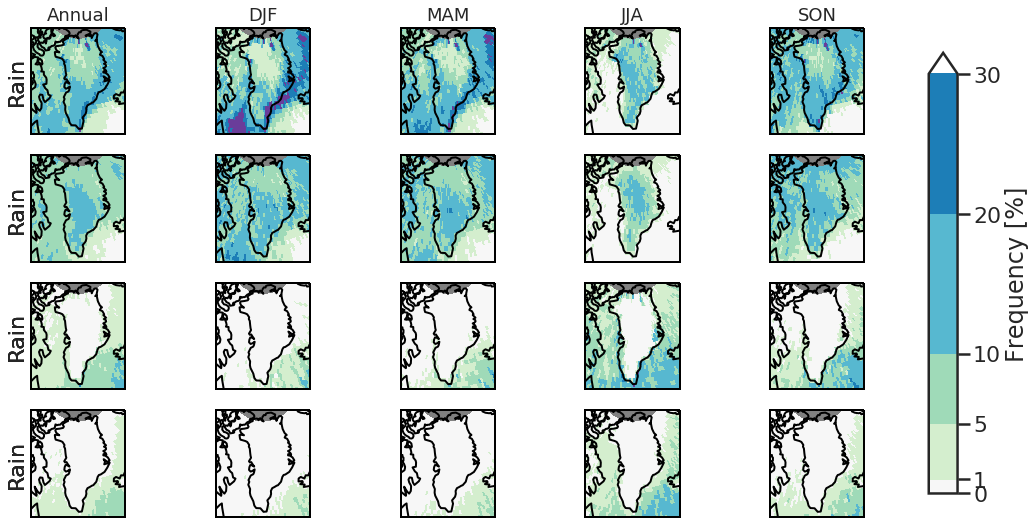

In [39]:
f, axes = plt.subplots(
            nrows=4, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']

levels = [0, 1, 5, 10, 20, 30]
colors = [(247/255, 247/255, 247/255)] 
colors += sns.color_palette('GnBu', len(levels) - 2)
colors += [(106/255, 61/255, 154/255)]


for l, var in enumerate(obs_plotvars):
    p = ((obs_lgtrain[var] / ds_obs['counts'] * 100)
         .mean('time')
         .plot.pcolormesh(
             ax=axes[l, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
             levels=levels, colors=colors)
    )

    for i, x in enumerate(seasons):
        ((obs_lgtrain[var] / ds_obs['counts'] * 100)
        .groupby('time.season')
        .mean('time')
        .sel(season=x)
        .plot.pcolormesh(
            ax=axes[l, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
            levels=levels, colors=colors)
        )
        
        axes[l, 0].text(-0.15, 0.5, 'Rain', fontsize=22,
                rotation='vertical', ha='center', va='center', transform=axes[l, 0].transAxes)
      
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])
    ax.background_patch.set_facecolor('gray')

#plt.tight_layout()
    
cb_ax = f.add_axes([0.93, 0.161, 0.025, 0.68])
cb = f.colorbar(p, cax=cb_ax, extend='max', spacing='proportional')
cb.ax.set_ylabel('Frequency [%]')


for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Supp_1_mapgrid-cloudsat-allvars.png',
         bbox_extra_artists=[ax for l in f.axes], bbox_inches='tight')

---
### Supp to Fig 3
Exploring topography distributions

In [40]:
indir_1km = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_Topo_Iceclasses_lon_lat_average_1km_GrIS.nc'
indir_1km_mask = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_orig.nc'
ds_1km = xr.open_dataset(indir_1km)
ds_1km = ds_1km.assign_coords(lon=ds_1km['LON']).assign_coords(lat=ds_1km['LAT'])
mask_1km = xr.open_dataarray(indir_1km_mask)
w_1km = np.ones_like(ds_1km['Topography']) / float(ds_1km['Topography'].count())

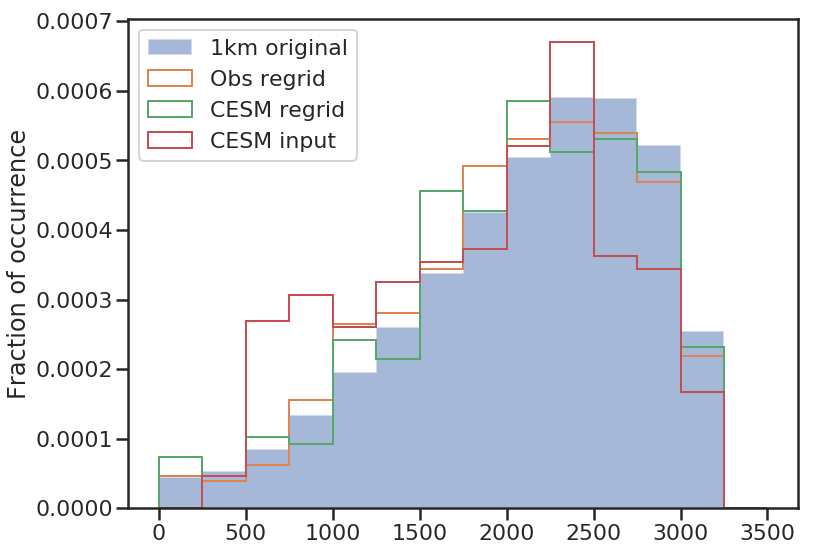

In [41]:
f, ax = plt.subplots(figsize=(12, 9))

_ = ((ds_1km['Topography'].where(mask_1km > 0))
     .plot.hist(ax=ax, bins=bins, histtype='stepfilled', density=True,
                linewidth=2, label='1km original', alpha=0.5))
_ = ((obs_mask['Topography'].where(obs_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step', density=True,
                linewidth=2, label='Obs regrid'))
_ = ((model_mask['Topography'].where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step', density=True,
                linewidth=2, label='CESM regrid'))
_ = ((topo_cesm.where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step', density=True,
                linewidth=2, label='CESM input'))

ax.legend(loc='upper left')
ax.set_ylabel('Fraction of occurrence')
ax.set_title('')

f.savefig('../figures/comps2/Supp_3_topo-hist.png', bbox_inches='tight')

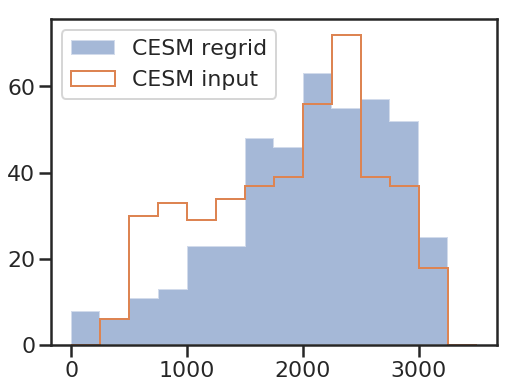

In [42]:
f, ax = plt.subplots(figsize=(8, 6))

_ = ((model_mask['Topography'] * model_mask['mask'].where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='stepfilled', alpha=0.5,
                linewidth=2, label='CESM regrid'))
_ = ((topo_cesm * model_mask['mask'].where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step',
                linewidth=2, label='CESM input'))

ax.legend(loc='upper left')
ax.set_title('')

f.savefig('../figures/comps2/Supp_3_topo_1km-vs-cesm.png', bbox_inches='tight')

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


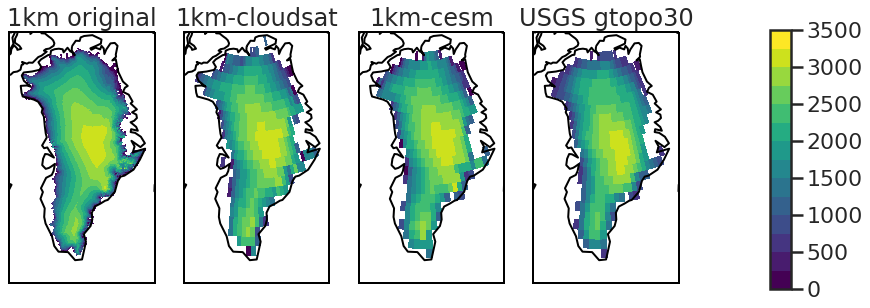

In [43]:
f, axes = plt.subplots(
            ncols=4, figsize=(12, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

levels = bins
p = (ds_1km['Topography'].where(mask_1km > 0)
     .plot.pcolormesh(x='lon', y='lat', ax=axes[0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))
_ = (obs_mask['Topography'].where(obs_mask['mask'] > 0)
     .plot.pcolormesh(ax=axes[1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))
_ = (model_mask['Topography'].where(model_mask['mask'] > 0)
     .plot.pcolormesh(ax=axes[2], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))
_ = (topo_cesm.where(model_mask['mask'] > 0)
     .plot.pcolormesh(ax=axes[3], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))

titles = ['1km original', '1km-cloudsat', '1km-cesm', 'USGS gtopo30']
for i, ax in enumerate(axes.flat):
    ax.coastlines(linewidth=2)
    ax.set_extent([303, 330, 57, 84])
    ax.set_title(titles[i])

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.3, 0.025, 0.4])
cb = f.colorbar(p, cax=cb_ax)

f.savefig('../figures/comps2/Supp_3_topo-maps.png', bbox_inches='tight')

In [44]:
print('Max abs. topo difference: %.f m'
      % (abs((topo_cesm - model_mask['Topography']).where(model_mask['mask'] > 0)).max().values))

Max abs. topo difference: 1312 m


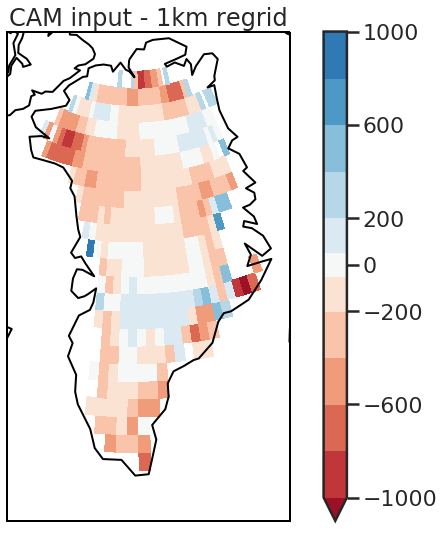

In [45]:
f, ax = plt.subplots(
            figsize=(12, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

levels = [-1000, -800, -600, -400, -200, -50, 50, 200, 400, 600, 800, 1000]
colors = sns.color_palette('RdBu', len(levels)+1)

p = ((topo_cesm - model_mask['Topography']).where(model_mask['mask'] > 0)
     .plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                      levels=levels, colors=colors))

ax.coastlines(linewidth=2)
ax.set_extent([303, 330, 57, 84])
    
cb = plt.colorbar(p, extend='min', spacing='proportional', ticks=[-1000, -600, -200, 0, 200, 600, 1000])

ax.set_title('CAM input - 1km regrid')

f.savefig('../figures/comps2/Supp_3_topo-usgs-bias.png', bbox_inches='tight')

In [46]:
obs_elev = np.zeros((len(obs_plotvars), (len(bins)-1)))
for i, var in enumerate(obs_plotvars):
    obs_elev[i,:] = ((obs_lgtrain[var] / ds_obs['counts'] * 100 * obs_mask['cell_area'])
                     .mean('time')
                     .where(obs_mask['mask'] > 0)
                     .groupby_bins(obs_mask['Topography'], bins, right=False)
                     .sum(dim=xr.ALL_DIMS) /
                     (obs_mask['cell_area'])
                     .where(obs_mask['mask'] > 0)
                     .groupby_bins(obs_mask['Topography'], bins, right=False)
                     .sum(dim=xr.ALL_DIMS)
                    ).values    

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:40089 remote=tcp://127.0.0.1:37070>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:40090 remote=tcp://127.0.0.1:37070>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:40091 remote=tcp://127.0.0.1:37070>


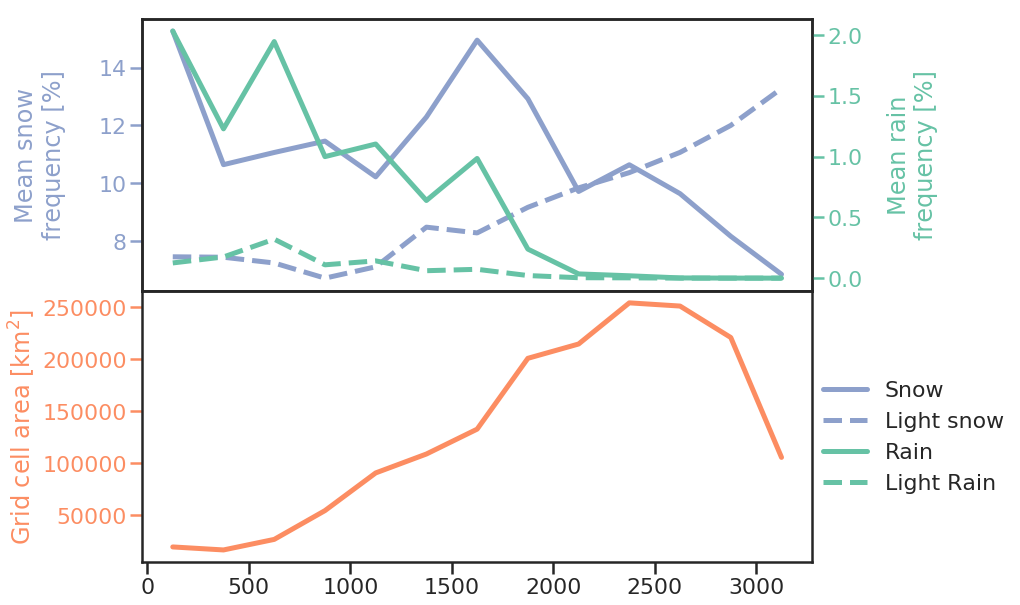

In [47]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)
axy=axes[0].twinx()

for i, label in enumerate(obs_vnames):
    if 'snow' in label.lower():
        axes[0].plot((bins[:-1]+125), obs_elev[i, :], color=sns.color_palette('Set2')[2], linestyle=obs_lstyle[i], label=label)
    else:
        axy.plot((bins[:-1]+125), obs_elev[i, :], color=sns.color_palette('Set2')[0], linestyle=obs_lstyle[i], label=label)

    
axes[1].plot(
    bins[:-1]+125, (obs_mask['cell_area'].where(obs_mask['mask'] > 0).groupby_bins(obs_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)


lines, labels = axes[0].get_legend_handles_labels()
linesy, labelsy = axy.get_legend_handles_labels()

axes[0].legend(lines+linesy, labels+labelsy, bbox_to_anchor=(1.3, -0.3), borderaxespad=0, frameon=False)
#axy.legend(bbox_to_anchor=(1.4, -0.6), borderaxespad=0, frameon=False)

axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Supp_3_elev-dist-obs-allvars.png', bbox_inches='tight')

---
### Supp to Fig 4
Maps of CESM 1 `present` (non-bias).

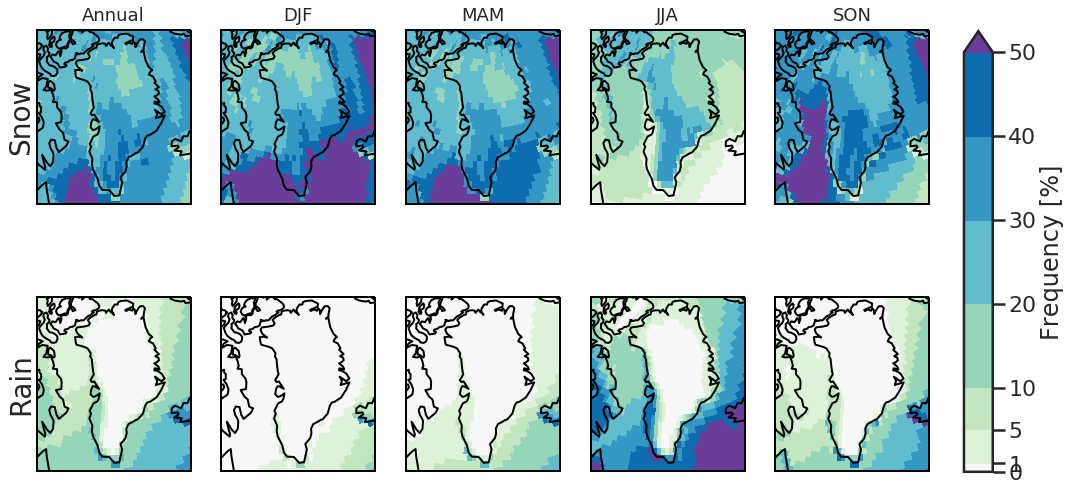

In [48]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

levels = [0, 1, 5, 10, 20, 30, 40, 50]
colors = [(247/255, 247/255, 247/255)] 
colors += sns.color_palette('GnBu', len(levels) - 2)
colors += [(106/255, 61/255, 154/255)]

p = (snow_pres
     .mean('time')
     .plot.pcolormesh(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    (snow_pres
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    
(rain_pres
 .mean('time')
 .plot.pcolormesh(
     ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    (rain_pres
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
        
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])

#plt.tight_layout()
    
cb_ax = f.add_axes([0.93, 0.161, 0.025, 0.68])
cb = f.colorbar(p, cax=cb_ax, extend='max', spacing='proportional')
cb.ax.set_ylabel('Frequency [%]')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=28, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=28,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Supp_4_mapgrid-present.png',
         bbox_extra_artists=[ax for l in axes for ax in l])#, bbox_inches='tight')

---
### Supp to Fig 5
`CESM present` seasonal cycle biases.

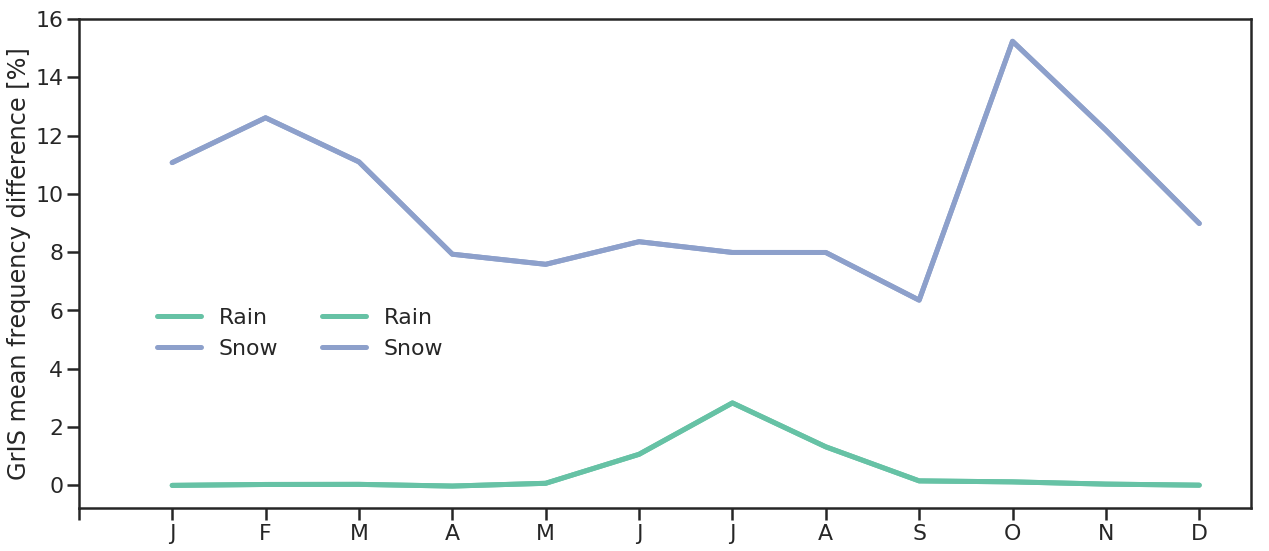

In [49]:
f, ax = plt.subplots(figsize=(21, 9))

model_colors = [0, 2]
for name, style, color in zip(model_vnames, model_lstyle, model_colors):
    ((
        ((rain_pres.where(model_mask['mask'] > 0) * model_mask['cell_area'])
         .sum('lat').sum('lon') / model_mask['cell_area'].where(model_mask['mask'] > 0).sum()) -
        ((rain_obs.where(obs_mask['mask'] > 0) * obs_mask['cell_area'])
         .sum('latitude').sum('longitude') / obs_mask['cell_area'].where(obs_mask['mask'] > 0).sum()))
        .groupby('time.month')
        .mean('time', skipna=True)
        .plot(ax=ax, label='Rain', color=sns.color_palette('Set2')[0])
    )
    
    ((
        ((snow_pres.where(model_mask['mask'] > 0) * model_mask['cell_area'])
         .sum('lat').sum('lon') / model_mask['cell_area'].where(model_mask['mask'] > 0).sum()) -
        ((snow_obs.where(obs_mask['mask'] > 0) * obs_mask['cell_area'])
         .sum('latitude').sum('longitude') / obs_mask['cell_area'].where(obs_mask['mask'] > 0).sum()))
        .groupby('time.month')
        .mean('time', skipna=True)
        .plot(ax=ax, label='Snow', color=sns.color_palette('Set2')[2])
    )
    
ax.autoscale(enable=True)    

ax.legend(loc=2, bbox_to_anchor=(0.05, 0.45), ncol=2, frameon=False)
plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel('GrIS mean frequency difference [%]')
ax.set_xlabel('')

f.savefig('../figures/comps2/Supp_5_GIS-presobs-bias-mean-cycle.png', bbox_inches='tight')

---
### Supp to Fig 6
Individual distributions and non-reduced investigation of frequency vs accumulation.

In [50]:
df_fig6_nomean = ds_fig6.where((model_mask['mask'] > 0), drop=True).to_dataframe().reset_index().dropna()

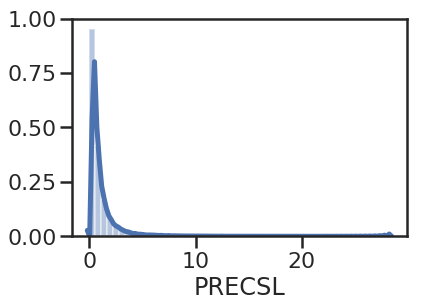

In [51]:
p = sns.distplot(df_fig6_nomean['PRECSL'])

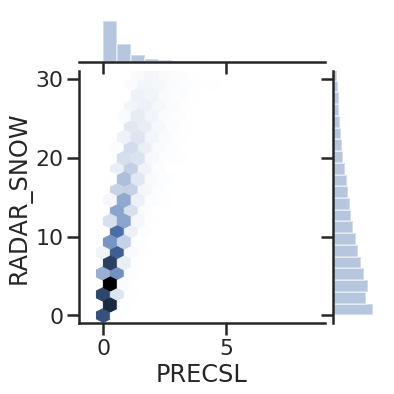

In [52]:
p = sns.jointplot(x='PRECSL', y='RADAR_SNOW', data=df_fig6_nomean, kind='hex', xlim=[-1, 9], ylim=[-1, 31])

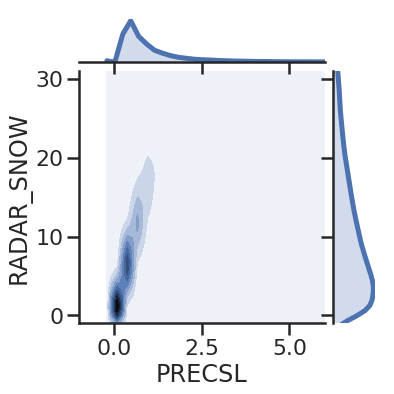

In [53]:
p = sns.jointplot(x='PRECSL', y='RADAR_SNOW', data=df_fig6_nomean, kind='kde', xlim=[-1, 6], ylim=[-1, 31])

#### Breakdown of contribution of non-snow to `PRECL`

In [54]:
frac_precsl = abs(ds_fig6['PRECL'].where(model_mask['mask'] > 0).sum().values - ds_fig6['PRECSL'].where(model_mask['mask'] > 0).sum().values) / ds_fig6['PRECL'].where(model_mask['mask'] > 0).sum().values * 100
print('Percentage of large scale precip that is non-snow: %.02f' % frac_precsl)

Percentage of large scale precip that is non-snow: 4.68


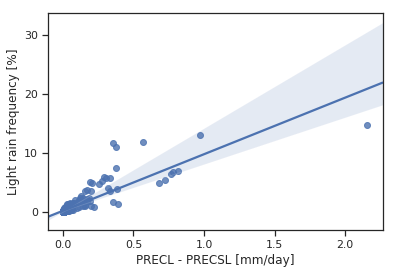

In [55]:
with sns.axes_style(style='ticks'):
    with sns.plotting_context('notebook'):
        f, ax = plt.subplots()
        sns.regplot(x=(df_fig6['PRECL'] - df_fig6['PRECSL']), y=df_fig6['RADAR_LGTRAIN'])
                
ax.set_xlabel('PRECL - PRECSL [mm/day]')
ax.set_ylabel('Light rain frequency [%]')
f.savefig('../figures/comps2/Supp_6_rain-vs-preclrain.png')

#### `CESM future` frequency-accumulation

In [56]:
# Converting PREC* vars from m/s to mm/day
ds_supp6 = xr.merge([(ds_fut[precvars] * 1000 * 86400), 
                    ds_fut[radarvars]])

In [57]:
df_supp6 = ds_supp6.where((model_mask['mask'] > 0), drop=True).mean('time').to_dataframe().reset_index().dropna()

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


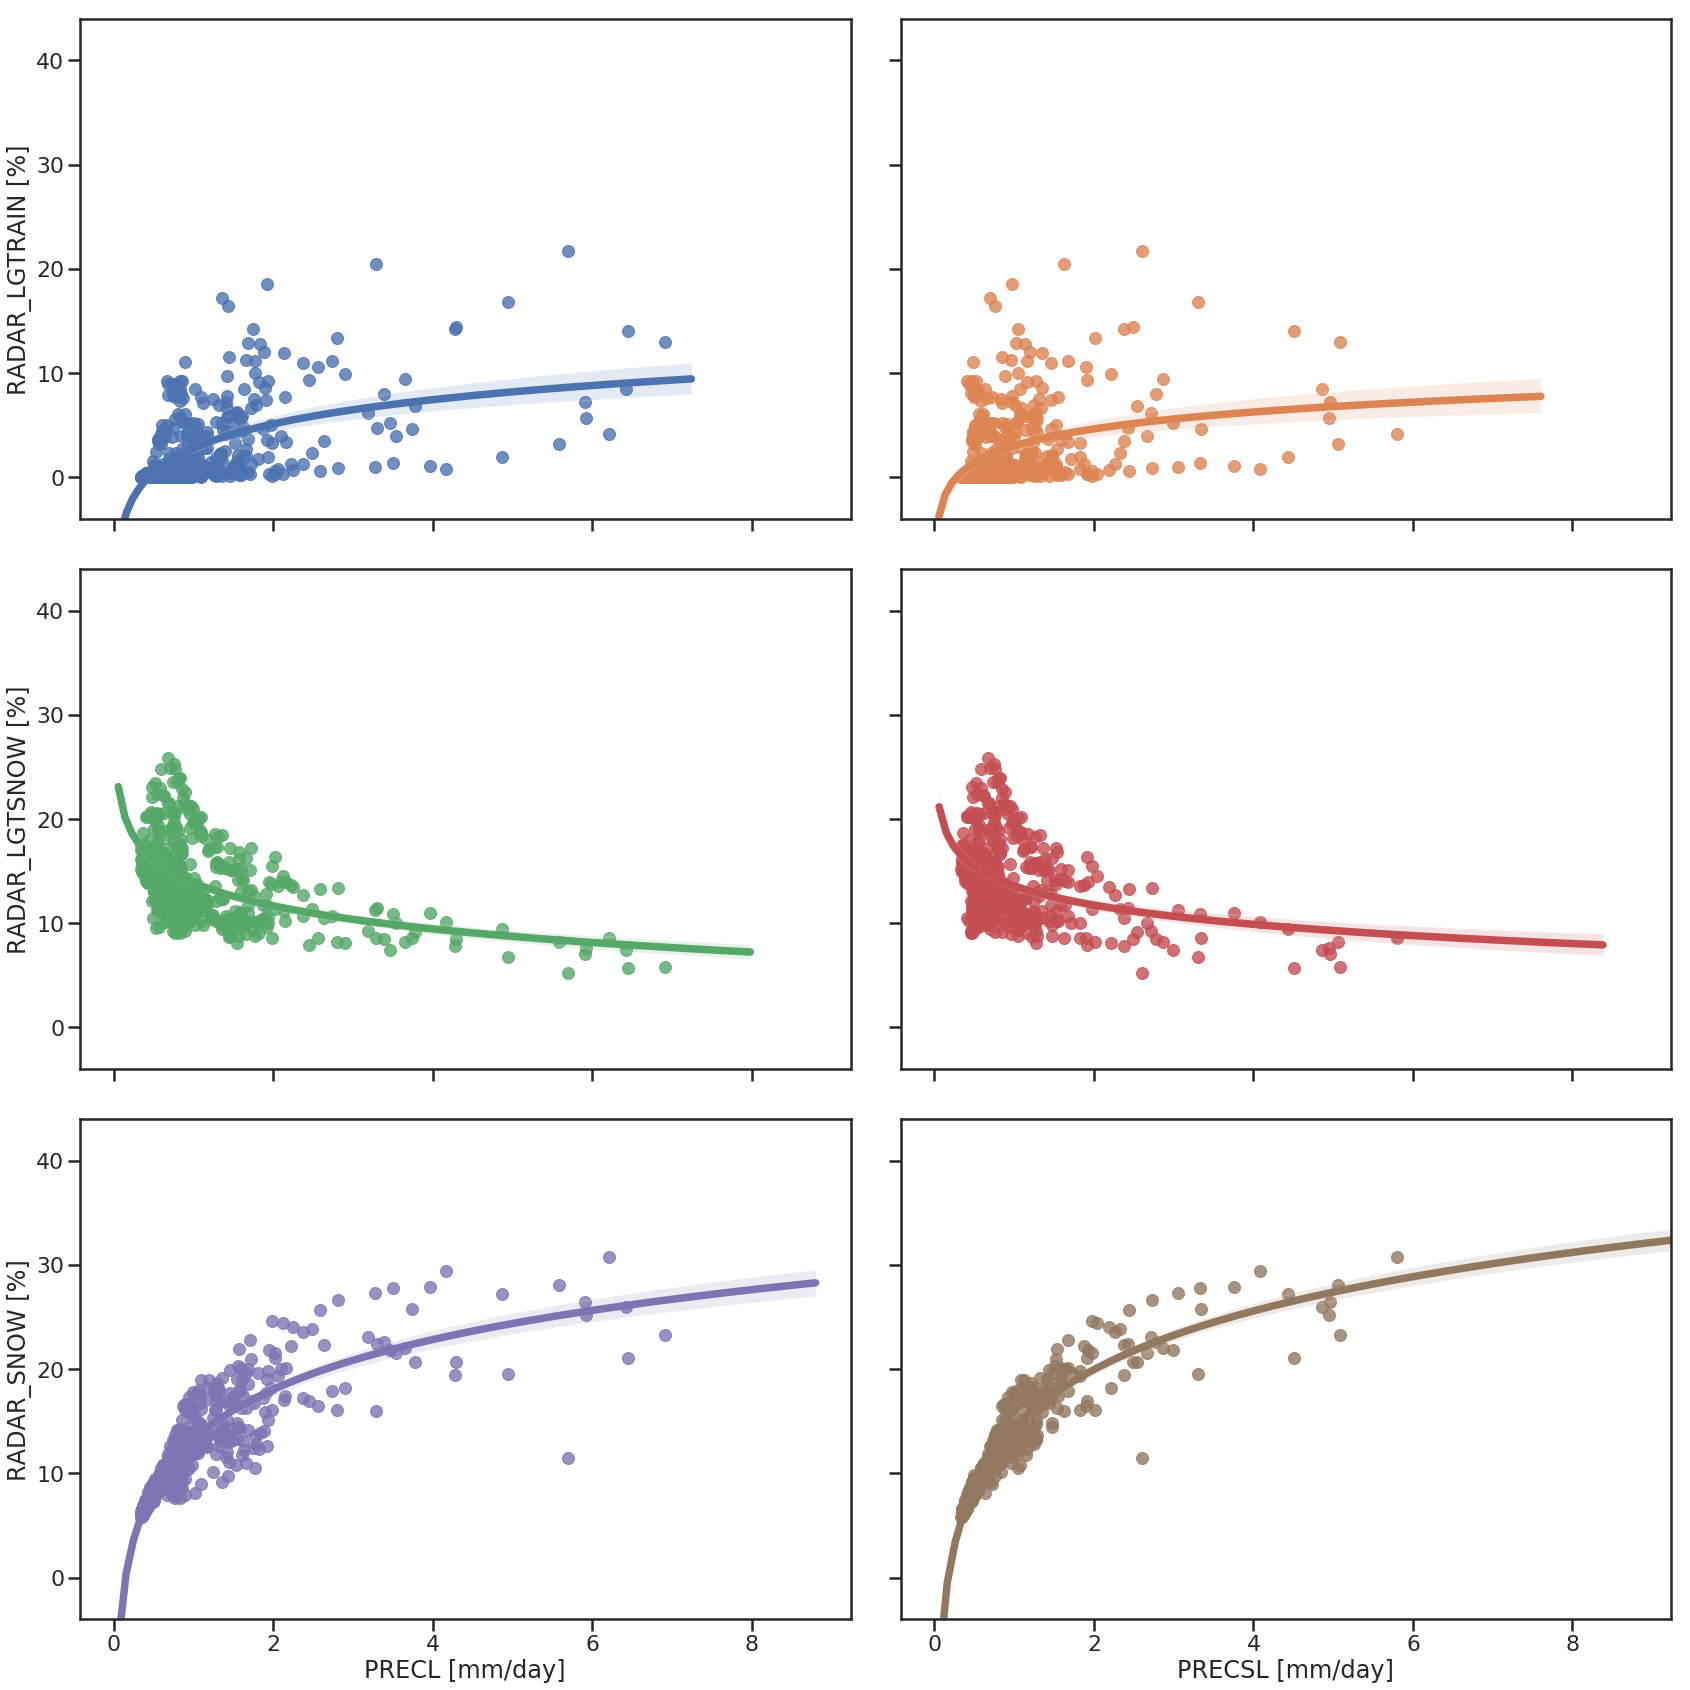

In [58]:
f, axes = plt.subplots(len(radarvars), len(precvars), figsize=(24, 24), sharex=True, sharey=True)

for iy, y in enumerate(radarvars):
    for ix, x in enumerate(precvars):
        sns.regplot(x=x, y=y, data=df_supp6, ax=axes[iy, ix], logx=True)
        
for ax in axes.flat:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-4, 44])
    
for i, x in enumerate(precvars):
    axes[-1, i].set_xlabel(x+' [mm/day]')
    
for i, y in enumerate(radarvars):
    axes[i, 0].set_ylabel(y+' [%]')
    
f.tight_layout()

---
### Supp to Fig 7
`CESM future - present` binned by USGS.

`CESM present` elevation distributions without Obs, with topo differences

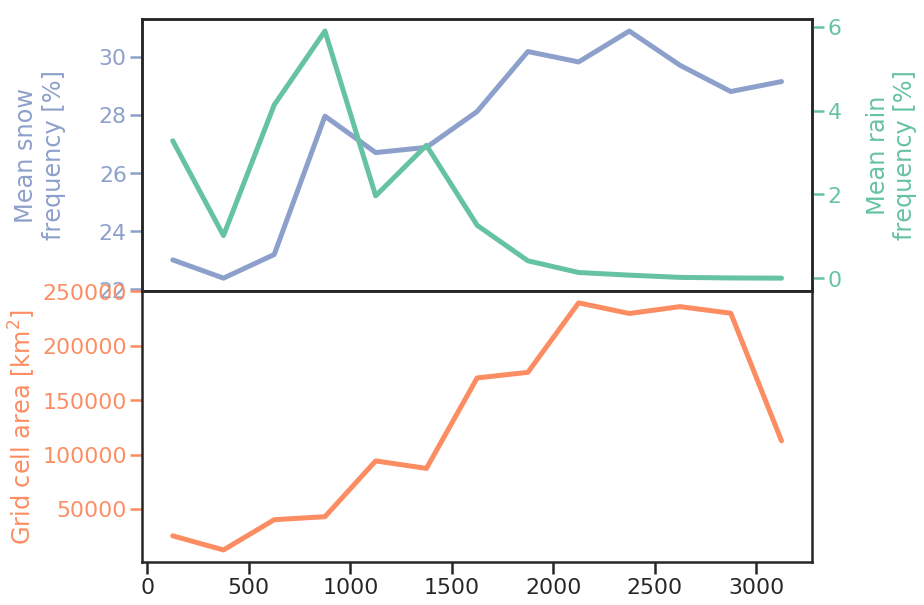

In [59]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot((bins[:-1]+125), snow_pres_elev, color=sns.color_palette('Set2')[2], label='Snow')
axy = axes[0].twinx()
axy.plot((bins[:-1]+125), rain_pres_elev, color=sns.color_palette('Set2')[0], label='Rain')

axes[1].plot(
    bins[:-1]+125, (model_mask['cell_area'].where(model_mask['mask'] > 0).groupby_bins(model_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])
#axes[0].set_ylim([16.5, 30.5])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])
#axy.set_ylim([-0.5, 9.5])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Supp_7_elev-dist-pres-1km.png')

In [60]:
snow_pres_elev_usgs = snow_pres.where(model_mask['mask'] > 0).groupby_bins(topo_cesm, bins, right=False).mean().values
rain_pres_elev_usgs = rain_pres.where(model_mask['mask'] > 0).groupby_bins(topo_cesm, bins, right=False).mean().values

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


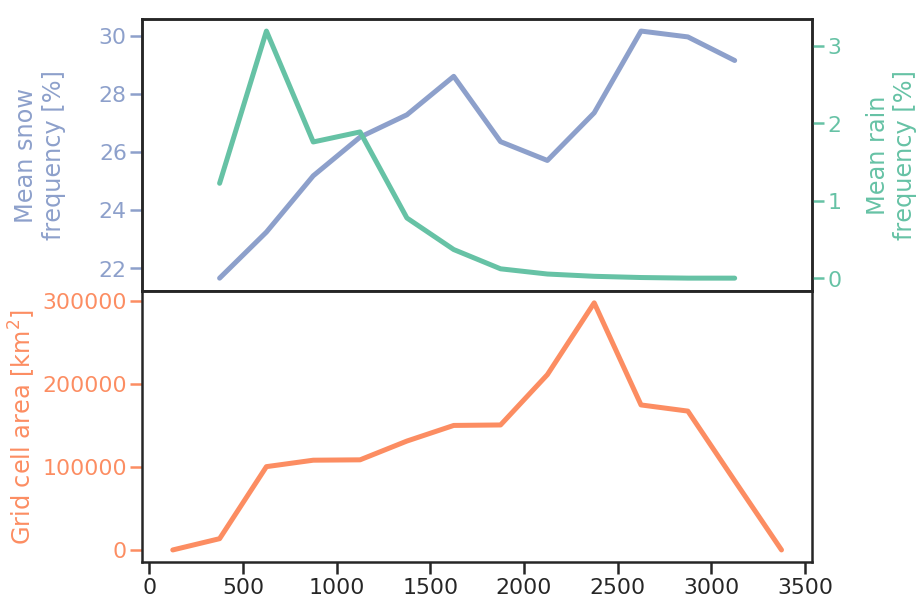

In [61]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot((bins[:-1]+125), snow_pres_elev_usgs, color=sns.color_palette('Set2')[2], label='Snow')
axy = axes[0].twinx()
axy.plot((bins[:-1]+125), rain_pres_elev_usgs, color=sns.color_palette('Set2')[0], label='Rain')

axes[1].plot(
    bins[:-1]+125, (model_mask['cell_area'].where(model_mask['mask'] > 0).groupby_bins(topo_cesm, bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])
#axes[0].set_ylim([11.5, 24.5])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])
#axy.set_ylim([-0.5, 4.5])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Supp_7_elev-dist-pres-usgs.png')

In [62]:
snow_fut_elev_usgs = snow_fut.where(model_mask['mask'] > 0).groupby_bins(topo_cesm, bins, right=False).mean().values
rain_fut_elev_usgs = rain_fut.where(model_mask['mask'] > 0).groupby_bins(topo_cesm, bins, right=False).mean().values

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


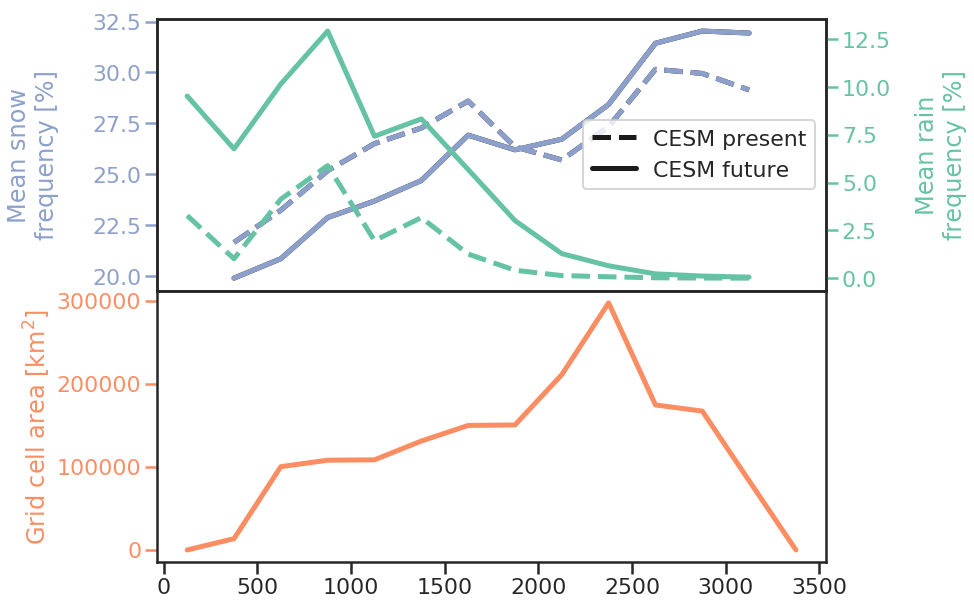

In [63]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot((bins[:-1]+125), snow_pres_elev_usgs, color='k', label='CESM present', linestyle='dashed')
axes[0].plot((bins[:-1]+125), snow_fut_elev_usgs, color='k', label='CESM future')

axes[0].plot((bins[:-1]+125), snow_pres_elev_usgs, color=sns.color_palette('Set2')[2], linestyle='dashed')
axes[0].plot((bins[:-1]+125), snow_fut_elev_usgs, color=sns.color_palette('Set2')[2])

axy = axes[0].twinx()
axy.plot((bins[:-1]+125), rain_pres_elev, color=sns.color_palette('Set2')[0], label='CESM present', linestyle='dashed')
axy.plot((bins[:-1]+125), rain_fut_elev, color=sns.color_palette('Set2')[0], label='CESM future')

axes[1].plot(
    bins[:-1]+125, (model_mask['cell_area'].where(model_mask['mask'] > 0).groupby_bins(topo_cesm, bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].legend(loc='center right')
axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])
#axes[0].set_ylim([11.5, 24.5])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])
#axy.set_ylim([-0.5, 4.5])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Supp_7_elev-dist-futpres-usgs.png')

In [64]:
pres_elev = np.zeros((len(model_vars), (len(bins)-1)))
for i, var in enumerate(model_vars):
    pres_elev[i,:] = ds_pres[var].where(model_mask['mask'] > 0).groupby_bins(model_mask['Topography'], bins, right=False).mean().values

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarra

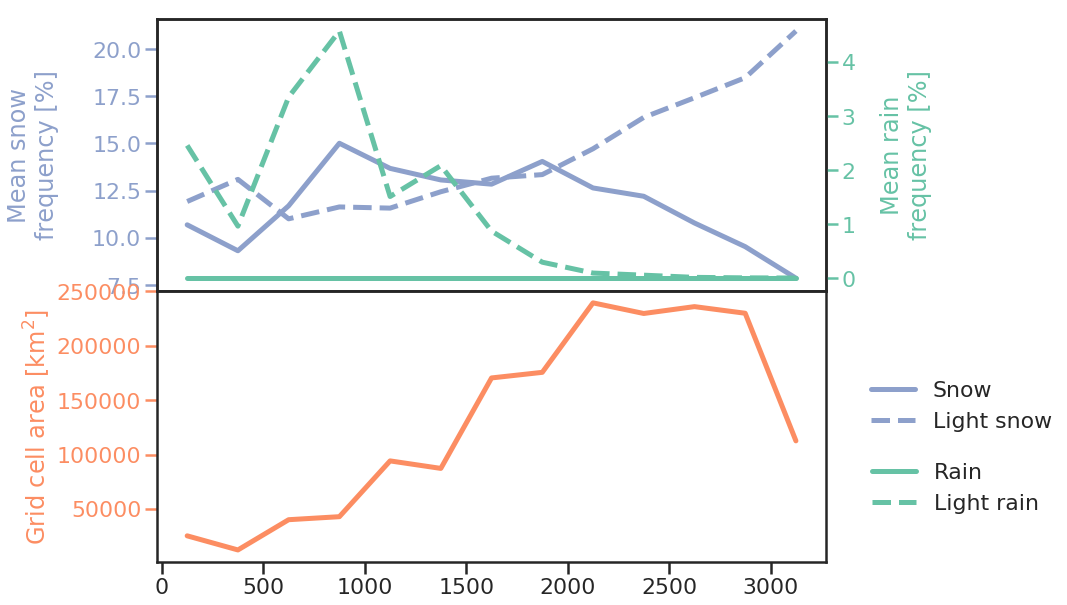

In [65]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)
axy=axes[0].twinx()

for i, label in enumerate(model_vnames):
    if 'SNOW' in model_vars[i]:
        axes[0].plot((bins[:-1]+125), pres_elev[i, :], color=sns.color_palette('Set2')[2], linestyle=model_lstyle[i], label=label)
    else:
        axy.plot((bins[:-1]+125), pres_elev[i, :], color=sns.color_palette('Set2')[0], linestyle=model_lstyle[i], label=label)

    
axes[1].plot(
    bins[:-1]+125, (model_mask['cell_area'].where(model_mask['mask'] > 0).groupby_bins(model_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].legend(bbox_to_anchor=(1.35, -0.3), borderaxespad=0, frameon=False)
axy.legend(bbox_to_anchor=(1.33, -0.6), borderaxespad=0, frameon=False)

axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Supp_3_elev-dist-pres-allvars.png')

In [66]:
fut_elev = np.zeros((len(model_vars), (len(bins)-1)))
for i, var in enumerate(model_vars):
    fut_elev[i,:] = ds_fut[var].where(model_mask['mask'] > 0).groupby_bins(model_mask['Topography'], bins, right=False).mean().values

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarra

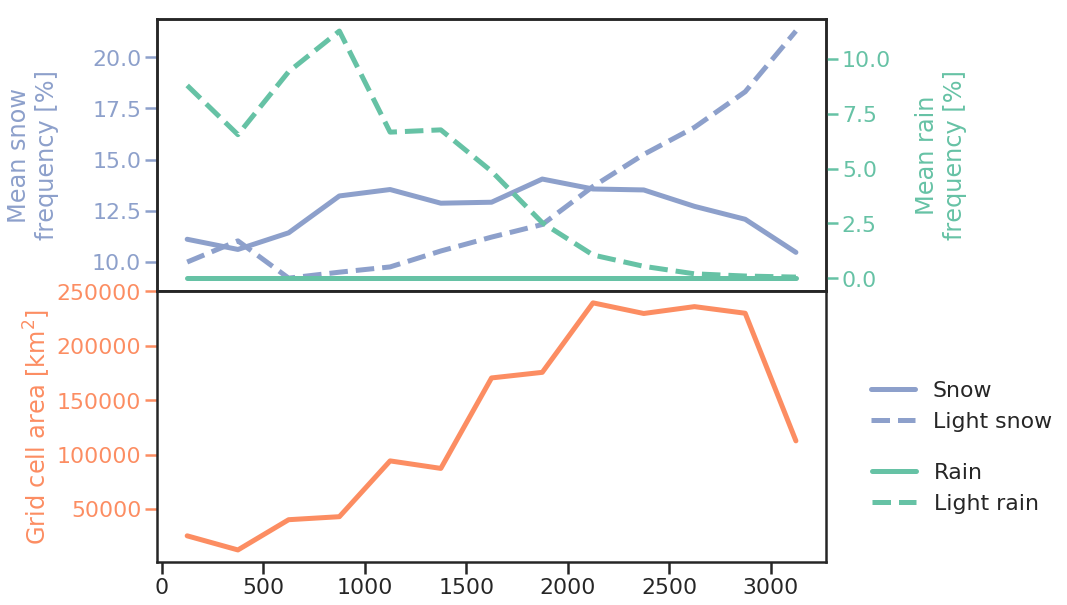

In [67]:
f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)
axy=axes[0].twinx()

for i, label in enumerate(model_vnames):
    if 'SNOW' in model_vars[i]:
        axes[0].plot((bins[:-1]+125), fut_elev[i, :], color=sns.color_palette('Set2')[2], linestyle=model_lstyle[i], label=label)
    else:
        axy.plot((bins[:-1]+125), fut_elev[i, :], color=sns.color_palette('Set2')[0], linestyle=model_lstyle[i], label=label)

    
axes[1].plot(
    bins[:-1]+125, (model_mask['cell_area'].where(model_mask['mask'] > 0).groupby_bins(model_mask['Topography'], bins=bins, right=False).sum() / 10**6),
    color=sns.color_palette('Set2')[1])

f.subplots_adjust(hspace=0)

axes[0].legend(bbox_to_anchor=(1.35, -0.3), borderaxespad=0, frameon=False)
axy.legend(bbox_to_anchor=(1.33, -0.6), borderaxespad=0, frameon=False)

axes[0].set_ylabel('Mean snow\nfrequency [%]', color=sns.color_palette('Set2')[2], labelpad=33)
axes[0].tick_params('y', colors=sns.color_palette('Set2')[2])

axy.set_ylabel('Mean rain\nfrequency [%]', color=sns.color_palette('Set2')[0], labelpad=24)
axy.tick_params('y', colors=sns.color_palette('Set2')[0])

axes[1].set_ylabel('Grid cell area [km$^2$]', color=sns.color_palette('Set2')[1])
axes[1].tick_params('y', colors=sns.color_palette('Set2')[1])
axes[1].set_title('')

f.savefig('../figures/comps2/Supp_3_elev-dist-fut-allvars.png')

---
### Supp to Fig 9
`CESM future` absolute seasonal. Add cycle relative to `CESM present`?

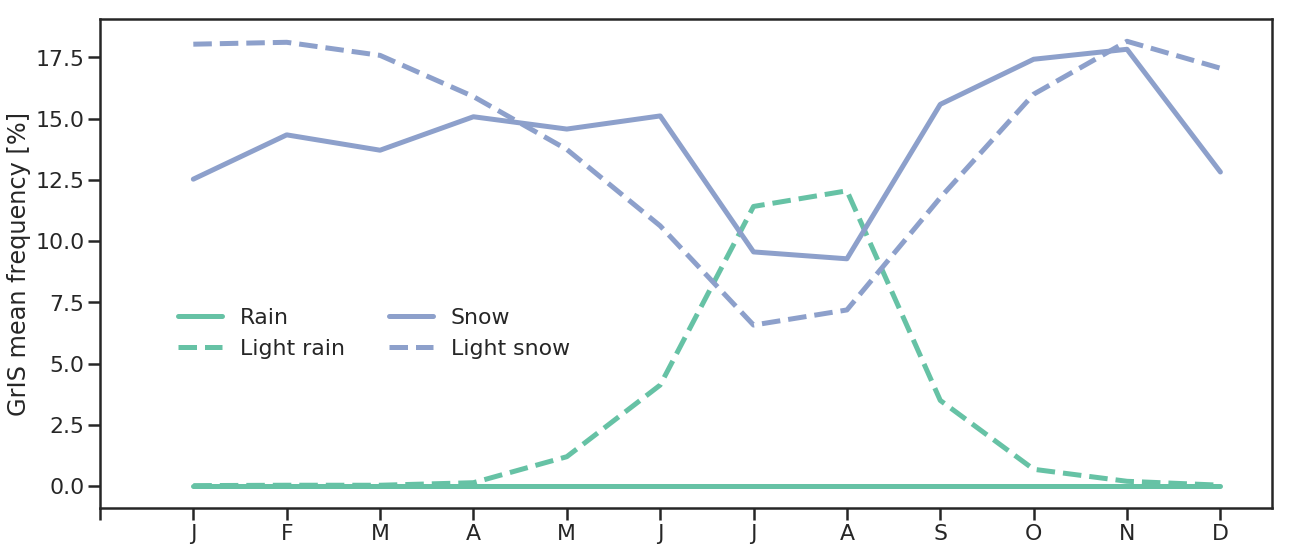

In [68]:
f, ax = plt.subplots(figsize=(21, 9))

model_vars = ['RADAR_RAIN', 'RADAR_LGTRAIN', 'RADAR_SNOW', 'RADAR_LGTSNOW']
model_vnames = ['Rain', 'Light rain', 'Snow', 'Light snow']
model_lstyle = ['solid', 'dashed', 'solid', 'dashed']
model_colors = [0, 0, 2, 2]
for var, name, style, color in zip(model_vars, model_vnames, model_lstyle, model_colors):
    ((
        (ds_fut[var] * model_mask['mask'].where(model_mask['mask'] > 0) * model_mask['cell_area'])
        .sum('lat').sum('lon') / (model_mask['mask'] * model_mask['cell_area']).sum())
        .groupby('time.month')
        .mean('time', skipna=True)
        .plot(ax=ax, label=name, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

ax.legend(loc=2, bbox_to_anchor=(0.05, 0.45), ncol=2, frameon=False)
plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel('GrIS mean frequency [%]')
ax.set_xlabel('')

f.savefig('../figures/comps2/Supp_9_GIS-fut-mean-cycle.png', bbox_inches='tight')